# Reading 

In [185]:
#processing
import pymysql.cursors 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scikitplot as skplt
from pandas import ExcelWriter
import scipy
scaler = StandardScaler()
label = LabelEncoder()
#NLP
import nltk
import re
import pymorphy2
from nltk.corpus import stopwords
#warnings
import warnings
warnings.filterwarnings('ignore')
#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)
import datetime
%matplotlib inline
#vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#model 
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score, train_test_split, KFold
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, f1_score, confusion_matrix, precision_score, recall_score, classification_report, accuracy_score

#classificators
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

from sklearn.utils import resample
from sklearn.externals import joblib
import IDF
from datetime import datetime

In [186]:
#Подключиться к базе данных
def con():
    conn = pymysql.connect(host='10.100.0.100', port=33062, user='i.serov', password='7*&y9EkL', db='mysql')
    return conn

In [187]:
%%time
df = pd.read_sql('''
SELECT
    p.amount,
    p.transaction_date,
    if(result_code = 0, 1, 0)                        AS is_success,
    p.result_text,
    day(p.transaction_date)                          AS day_of_month_of_spisanie,
    dayofweek(p.transaction_date)                    AS day_of_week_of_spisanie,
    p.credit_id,
    if(crf.instantor_user_details_id is not NULL,1,0) as is_instantor,
    cc1.bonus_amount, cc1.calculation_date, cc1.expired_debt,
    cc1.main_debt, cc1.main_debt_repaid, cc1.payments_amount, cc1.penalty_charge,
    cc1.penalty_debt, cc1.penalty_repaid, cc1.percent_charge, cc1.percent_debt,
    cc1.percent_repaid, cc1.status_days_count, cc1.status_reason_code,
    cc1.total_debt, cc1.overpaid, cc1.total_payed, cc1.commission_amount, cc1.forgiven_amount, cc1.expired_days_count,

    floor(datediff(curdate(),p_d.birthday) / 365) AS age, p_d.dependants_count, p_d.maritalStatus,
    p_d.sex, p_d.habitation_old, p_d.habitation, p_d.payments_loans,
    p_d.payments_loans_currency, p_d.credit_purpose_id,

    datediff(curdate(), i.date) as iovation_date, i.result, i.device_new, i.device_type, i.device_tz,
    i.device_js_enabled, i.device_flash_enabled, i.device_flash_installed,
    i.device_flash_storage_enabled, i.device_flash_cookie_enabled, i.device_browser_type,
    i.ruleset_rulesmatched, i.ruleset_score,

    datediff(day(w.next_income_date), day(c.date_requested))   AS days_bef_sal_aft_request,
    datediff(day(p.transaction_date), day(w.next_income_date)) AS days_bef_income,
    p.amount / cc1.expired_debt                      AS percent_of_debt,
    c.credit_number,
    if(monthly_salary_count_M1 is not null or monthly_salary_count_M2 is not null or monthly_salary_count_M3 is not null,1,0) as inst_salary_flag,
    if(direct_debit_amount_M3 IS NOT NULL OR
       direct_debit_amount_M2 IS NOT NULL OR
       direct_debit_amount_M1 IS NOT NULL OR
       inn.microlenders_amount_M3 IS NOT NULL OR
       inn.microlenders_amount_M2 IS NOT NULL OR
       inn.microlenders_amount_M1 IS NOT NULL OR
       inn.other_lenders_amount_M1 IS NOT NULL OR
       inn.other_lenders_amount_M2 IS NOT NULL OR
       inn.other_lenders_amount_M3 IS NOT NULL, 1, 0)   AS suc_trans_of_MFO,
    crf.scoring_result30,
    crf.scoring_result12,
    crf.scoring_result11,
    iba.*,

    ########DD PAYMENTS###############
    ifnull((select count(id) from moneyman_es.payment pin
    where p.credit_id = pin.credit_id
          and pin.id < p.id
          and result_code = 0 AND recurrent IS TRUE
    group by pin.credit_id ),0) as DD_cnt_usp_credit,

    ifnull((select count(pin.id) from moneyman_es.payment pin LEFT JOIN moneyman_es.credit c2 ON pin.credit_id = c2.id
    where b.id = c2.borrower_id and pin.id < p.id
          and result_code = 0 AND recurrent IS TRUE
    group by c2.borrower_id ),0) as DD_cnt_usp_borrower,

    ifnull((select count(id) from moneyman_es.payment pin
    where p.credit_id = pin.credit_id
          and pin.id < p.id
          and result_code > 0 AND recurrent IS TRUE
    group by pin.credit_id ),0) as DD_cnt_neusp_credit,

    ifnull((select count(pin.id) from moneyman_es.payment pin LEFT JOIN moneyman_es.credit c2 ON pin.credit_id = c2.id
    where b.id = c2.borrower_id and pin.id < p.id
          and result_code > 0 AND recurrent IS TRUE
    group by c2.borrower_id ),0) as DD_cnt_neusp_borrower,

    ##############NOT DD###########
    ifnull((select count(id) from moneyman_es.payment pin
    where p.credit_id = pin.credit_id
          and pin.id < p.id
          and result_code = 0 AND recurrent IS FALSE
    group by pin.credit_id ),0) as NOT_DD_cnt_usp_credit,

    ifnull((select count(pin.id) from moneyman_es.payment pin LEFT JOIN moneyman_es.credit c2 ON pin.credit_id = c2.id
    where b.id = c2.borrower_id and pin.id < p.id
          and result_code = 0 AND recurrent IS FALSE
    group by c2.borrower_id ),0) as NOT_DD_cnt_usp_borrower,

    ifnull((select count(id) from moneyman_es.payment pin
    where p.credit_id = pin.credit_id
          and pin.id < p.id
          and result_code > 0 AND recurrent IS FALSE
    group by pin.credit_id ),0) as NOT_DD_cnt_neusp_credit,

    ifnull((select count(pin.id) from moneyman_es.payment pin LEFT JOIN moneyman_es.credit c2 ON pin.credit_id = c2.id
    where b.id = c2.borrower_id and pin.id < p.id
          and result_code > 0 AND recurrent IS FALSE
    group by c2.borrower_id ),0) as NOT_DD_cnt_neusp_borrower,

    ifnull((SELECT result_text FROM moneyman_es.payment pin WHERE p.credit_id = pin.credit_id
and pin.id < p.id ORDER BY id desc limit 1), 'No_trans_of_credit') as prev_result_text

FROM moneyman_es.payment p
  LEFT JOIN moneyman_es.credit c ON p.credit_id = c.id
  LEFT JOIN moneyman_es.credit_calculations cc1
    ON p.credit_id = cc1.credit_id AND p.transaction_date = (cc1.calculation_date + INTERVAL 1 DAY)
  LEFT JOIN moneyman_es.borrower b ON c.borrower_id = b.id
   LEFT JOIN moneyman_es.work w ON b.work_id = w.id
   LEFT JOIN moneyman_es.personal_data p_d ON b.personal_data_id = p_d.id
   LEFT JOIN moneyman_es.iovation i on i.credit_id = c.id
   LEFT JOIN moneyman_es.credit_risk_filter crf on c.id = crf.credit_id
   LEFT JOIN moneyman_es.instantor_user_details detail ON b.id = detail.borrower_id
   LEFT JOIN moneyman_es.instantor_bank_account iba ON detail.id = iba.instantor_user_details_id
    LEFT JOIN moneyman_es.instantor_agg_positive_total iapt ON iapt.credit_id=p.credit_id
    LEFT JOIN moneyman_es.instantor_agg_negative_total inn ON c.id = inn.credit_id
WHERE
    day(p.transaction_date) NOT IN (29, 30, 31, 1, 2, 10, 25) AND p.result_code >= 0 AND
    p.recurrent IS TRUE and p.transaction_date>'2018-02-01' and p.transaction_date<'2018-03-22' and p.credit_id is not NULL 
ORDER BY p.credit_id DESC;
''', con=con())

Wall time: 6min 24s


In [132]:
df1.habitation_old.value_counts()

5    4893
4    3961
0    2856
3    2748
2    2154
6    1146
1     989
Name: habitation_old, dtype: int64

In [133]:
df.habitation_old.value_counts()

0    409100
6      4893
5      3961
1      2856
4      2748
3      2154
7      1146
2       989
Name: habitation_old, dtype: int64

11. день месяца списания
12. день недели списания
13. наличие флага зп инстантора
14. разница между днем попытки и днем зп
15. количество предыдущих успешных попыток (за всю историю и предыдущий)
16. количество предыдущих неуспешных попыток (за всю историю и предыдущий)
17. максимальный день просрочки по клиенту
18. максимальная сумма просрочки по клиенту
19. соотношение суммы списания к долгу
20. новый\старый клиент
21. разница между днем займа и днем зп
22. число дней от первого займа и от предыдущего займа
23. код ответа по предыдущей попытке
24. согласие на DD по текущему займу или по одному из предыдущих
25. может добавить вообще аппликационный скор

In [188]:
df1 = df.copy()
#df = df1.copy()

In [123]:
#df = train.copy()

In [69]:
'''# downsample the data
def downsample(df):
    df_suc = df[df.y==1]
    df_fail = df[df.y==0]
    df_fail_ds = resample(df_fail,replace=False,n_samples=20000,random_state=123)
    df_downsampled = pd.concat([df_fail_ds, df_suc])
    df_downsampled = df_downsampled.sample(frac=1).reset_index(drop=True)
    return df_downsampled
df_downsampled = downsample(df)''';

In [70]:
#df_downsampled.y.value_counts()

0    20000
1     3955
Name: y, dtype: int64

In [71]:
#df = df_downsampled.copy()

# Data Exploration

In [195]:
#df['age'] = 2018 - df['birthday'].apply(lambda x: x.year)
#df = df[df.transaction_date<'2017-12-01']
df = df1.copy()

In [196]:
def preproc(df, downsample=True):
    df.drop(['result_text','calculation_date','id','instantor_user_details_id','number', 'kind',
             'currency', 'iban', 'account_number', 'holder_name','credit_id'], axis = 1, inplace = True)
    df.fillna(-1, inplace=True)
    cat_vars = ['status_reason_code', 'maritalStatus','sex', 'habitation_old', 'habitation','result',
               'prev_result_text', 'device_new', 'device_type', 'device_tz', 'device_browser_type']
    for i in cat_vars:
        df[i]=label.fit_transform(df[i].astype(str))
    #df = df[df.DD_cnt_usp_credit>0]
    train = df[df.transaction_date<datetime.date(datetime.strptime('2018-03-01', '%Y-%m-%d'))]
    test = df[df.transaction_date>=datetime.date(datetime.strptime('2018-03-01', '%Y-%m-%d'))]
    
    if downsample:
        train_suc = train[train.is_success==1]
        train_fail = train[train.is_success==0]
        train_fail_ds = resample(train_fail,replace=False,n_samples=15000,random_state=123)
        train_downsampled = pd.concat([train_fail_ds, train_suc])
        train = train_downsampled.sample(frac=1).reset_index(drop=True)
    
    y_train = train.is_success
    X_train = train.drop(['is_success', 'transaction_date'], axis=1)
    y_test = test.is_success
    X_test = test.drop(['is_success', 'transaction_date'], axis=1)
    return X_train, X_test, y_train, y_test

In [197]:
X_train, X_test, y_train, y_test = preproc(df, downsample=True)

# Model Preds

In [121]:
%%time
# model training
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
clf = GradientBoostingClassifier(random_state=1, verbose = 0,
                                 learning_rate = 0.1,
                                 max_depth = 5,
                                 n_estimators = 100).fit(X_train, y_train)
#joblib.dump(clf, 'DD_end/ES_DD_model_v2.pkl');
#clf = joblib.load('DD_end/ES_DD_model.pkl');

Wall time: 22.6 s


In [198]:
clf = CatBoostClassifier().fit(X_train, y_train)

0: learn: 0.67819	total: 83.4ms	remaining: 1m 23s
1: learn: 0.6637763	total: 156ms	remaining: 1m 18s
2: learn: 0.649792	total: 250ms	remaining: 1m 23s
3: learn: 0.6366609	total: 315ms	remaining: 1m 18s
4: learn: 0.6246694	total: 381ms	remaining: 1m 15s
5: learn: 0.6134629	total: 445ms	remaining: 1m 13s
6: learn: 0.6021155	total: 514ms	remaining: 1m 12s
7: learn: 0.5916287	total: 578ms	remaining: 1m 11s
8: learn: 0.5815881	total: 645ms	remaining: 1m 11s
9: learn: 0.5732575	total: 708ms	remaining: 1m 10s
10: learn: 0.5650017	total: 781ms	remaining: 1m 10s
11: learn: 0.5574555	total: 842ms	remaining: 1m 9s
12: learn: 0.5503478	total: 903ms	remaining: 1m 8s
13: learn: 0.5438004	total: 965ms	remaining: 1m 7s
14: learn: 0.5375525	total: 1.03s	remaining: 1m 7s
15: learn: 0.5316335	total: 1.1s	remaining: 1m 7s
16: learn: 0.5256275	total: 1.16s	remaining: 1m 7s
17: learn: 0.5204435	total: 1.23s	remaining: 1m 7s
18: learn: 0.5151941	total: 1.3s	remaining: 1m 6s
19: learn: 0.5106605	total: 1.36s	

161: learn: 0.3725586	total: 10.7s	remaining: 55.5s
162: learn: 0.3724326	total: 10.8s	remaining: 55.4s
163: learn: 0.3720835	total: 10.9s	remaining: 55.4s
164: learn: 0.3716549	total: 10.9s	remaining: 55.3s
165: learn: 0.3714425	total: 11s	remaining: 55.2s
166: learn: 0.3710839	total: 11.1s	remaining: 55.2s
167: learn: 0.3707552	total: 11.1s	remaining: 55.1s
168: learn: 0.370608	total: 11.2s	remaining: 55s
169: learn: 0.3701802	total: 11.3s	remaining: 54.9s
170: learn: 0.3699258	total: 11.3s	remaining: 54.8s
171: learn: 0.3693633	total: 11.4s	remaining: 54.8s
172: learn: 0.3691932	total: 11.4s	remaining: 54.7s
173: learn: 0.3687124	total: 11.5s	remaining: 54.6s
174: learn: 0.3684348	total: 11.6s	remaining: 54.6s
175: learn: 0.368218	total: 11.6s	remaining: 54.5s
176: learn: 0.367819	total: 11.7s	remaining: 54.4s
177: learn: 0.3676456	total: 11.8s	remaining: 54.3s
178: learn: 0.3674398	total: 11.8s	remaining: 54.3s
179: learn: 0.3672034	total: 11.9s	remaining: 54.2s
180: learn: 0.36677

321: learn: 0.3322352	total: 21.1s	remaining: 44.5s
322: learn: 0.3318824	total: 21.2s	remaining: 44.5s
323: learn: 0.3316296	total: 21.3s	remaining: 44.4s
324: learn: 0.3314248	total: 21.3s	remaining: 44.3s
325: learn: 0.3311779	total: 21.4s	remaining: 44.3s
326: learn: 0.3308251	total: 21.5s	remaining: 44.2s
327: learn: 0.3307192	total: 21.5s	remaining: 44.1s
328: learn: 0.3305735	total: 21.6s	remaining: 44s
329: learn: 0.330395	total: 21.7s	remaining: 44s
330: learn: 0.3302425	total: 21.7s	remaining: 43.9s
331: learn: 0.3300168	total: 21.8s	remaining: 43.8s
332: learn: 0.3297219	total: 21.8s	remaining: 43.8s
333: learn: 0.3295355	total: 21.9s	remaining: 43.7s
334: learn: 0.3292691	total: 22s	remaining: 43.6s
335: learn: 0.3290646	total: 22s	remaining: 43.6s
336: learn: 0.3289742	total: 22.1s	remaining: 43.5s
337: learn: 0.3287598	total: 22.2s	remaining: 43.4s
338: learn: 0.3286302	total: 22.2s	remaining: 43.4s
339: learn: 0.3283056	total: 22.3s	remaining: 43.3s
340: learn: 0.3282036

482: learn: 0.29913	total: 31.6s	remaining: 33.9s
483: learn: 0.2989367	total: 31.7s	remaining: 33.8s
484: learn: 0.2987858	total: 31.8s	remaining: 33.7s
485: learn: 0.2986786	total: 31.8s	remaining: 33.7s
486: learn: 0.2985175	total: 31.9s	remaining: 33.6s
487: learn: 0.2983356	total: 32s	remaining: 33.5s
488: learn: 0.2982711	total: 32s	remaining: 33.5s
489: learn: 0.2981237	total: 32.1s	remaining: 33.4s
490: learn: 0.2979329	total: 32.2s	remaining: 33.3s
491: learn: 0.2978567	total: 32.2s	remaining: 33.3s
492: learn: 0.2974682	total: 32.3s	remaining: 33.2s
493: learn: 0.2971875	total: 32.3s	remaining: 33.1s
494: learn: 0.2970392	total: 32.4s	remaining: 33.1s
495: learn: 0.2967637	total: 32.5s	remaining: 33s
496: learn: 0.2965945	total: 32.5s	remaining: 32.9s
497: learn: 0.296493	total: 32.6s	remaining: 32.9s
498: learn: 0.296345	total: 32.7s	remaining: 32.8s
499: learn: 0.2961545	total: 32.7s	remaining: 32.7s
500: learn: 0.2959625	total: 32.8s	remaining: 32.7s
501: learn: 0.2956762	

645: learn: 0.2749085	total: 42.5s	remaining: 23.3s
646: learn: 0.2747519	total: 42.6s	remaining: 23.2s
647: learn: 0.2746741	total: 42.7s	remaining: 23.2s
648: learn: 0.2745473	total: 42.7s	remaining: 23.1s
649: learn: 0.2743853	total: 42.8s	remaining: 23s
650: learn: 0.2743197	total: 42.9s	remaining: 23s
651: learn: 0.2742266	total: 42.9s	remaining: 22.9s
652: learn: 0.2740842	total: 43s	remaining: 22.8s
653: learn: 0.2739003	total: 43.1s	remaining: 22.8s
654: learn: 0.2737383	total: 43.1s	remaining: 22.7s
655: learn: 0.2736501	total: 43.2s	remaining: 22.6s
656: learn: 0.2734656	total: 43.3s	remaining: 22.6s
657: learn: 0.273283	total: 43.3s	remaining: 22.5s
658: learn: 0.2732173	total: 43.4s	remaining: 22.5s
659: learn: 0.2731496	total: 43.5s	remaining: 22.4s
660: learn: 0.2729645	total: 43.5s	remaining: 22.3s
661: learn: 0.2727919	total: 43.6s	remaining: 22.3s
662: learn: 0.2727123	total: 43.7s	remaining: 22.2s
663: learn: 0.272624	total: 43.7s	remaining: 22.1s
664: learn: 0.272453

805: learn: 0.2570281	total: 53.2s	remaining: 12.8s
806: learn: 0.2569884	total: 53.3s	remaining: 12.7s
807: learn: 0.2568916	total: 53.3s	remaining: 12.7s
808: learn: 0.25678	total: 53.4s	remaining: 12.6s
809: learn: 0.2567176	total: 53.5s	remaining: 12.5s
810: learn: 0.2566431	total: 53.5s	remaining: 12.5s
811: learn: 0.2565019	total: 53.6s	remaining: 12.4s
812: learn: 0.2564379	total: 53.7s	remaining: 12.3s
813: learn: 0.2563069	total: 53.7s	remaining: 12.3s
814: learn: 0.2562395	total: 53.8s	remaining: 12.2s
815: learn: 0.2561228	total: 53.9s	remaining: 12.1s
816: learn: 0.2559708	total: 53.9s	remaining: 12.1s
817: learn: 0.2558605	total: 54s	remaining: 12s
818: learn: 0.2557502	total: 54s	remaining: 11.9s
819: learn: 0.2555408	total: 54.1s	remaining: 11.9s
820: learn: 0.2554841	total: 54.2s	remaining: 11.8s
821: learn: 0.2553602	total: 54.2s	remaining: 11.7s
822: learn: 0.2552537	total: 54.3s	remaining: 11.7s
823: learn: 0.2551355	total: 54.4s	remaining: 11.6s
824: learn: 0.254992

968: learn: 0.241025	total: 1m 3s	remaining: 2.04s
969: learn: 0.2409383	total: 1m 3s	remaining: 1.98s
970: learn: 0.2408992	total: 1m 3s	remaining: 1.91s
971: learn: 0.2407872	total: 1m 4s	remaining: 1.84s
972: learn: 0.2407324	total: 1m 4s	remaining: 1.78s
973: learn: 0.2406923	total: 1m 4s	remaining: 1.71s
974: learn: 0.2406064	total: 1m 4s	remaining: 1.65s
975: learn: 0.2405394	total: 1m 4s	remaining: 1.58s
976: learn: 0.2404326	total: 1m 4s	remaining: 1.51s
977: learn: 0.2403333	total: 1m 4s	remaining: 1.45s
978: learn: 0.2402247	total: 1m 4s	remaining: 1.38s
979: learn: 0.2401273	total: 1m 4s	remaining: 1.32s
980: learn: 0.240071	total: 1m 4s	remaining: 1.25s
981: learn: 0.2400003	total: 1m 4s	remaining: 1.19s
982: learn: 0.2399089	total: 1m 4s	remaining: 1.12s
983: learn: 0.2398277	total: 1m 4s	remaining: 1.05s
984: learn: 0.2396796	total: 1m 4s	remaining: 988ms
985: learn: 0.2396245	total: 1m 4s	remaining: 922ms
986: learn: 0.2394784	total: 1m 5s	remaining: 857ms
987: learn: 0.

Confusion Matrix:
[[147521   2127]
 [ 20813   5049]]


ROC_AUC:  0.5905075833026627
Gini:  0.18101516660532546
F1_score:  0.3056480416490102


Classification_report: 
              precision    recall  f1-score   support

        0.0       0.88      0.99      0.93    149648
        1.0       0.70      0.20      0.31     25862

avg / total       0.85      0.87      0.84    175510





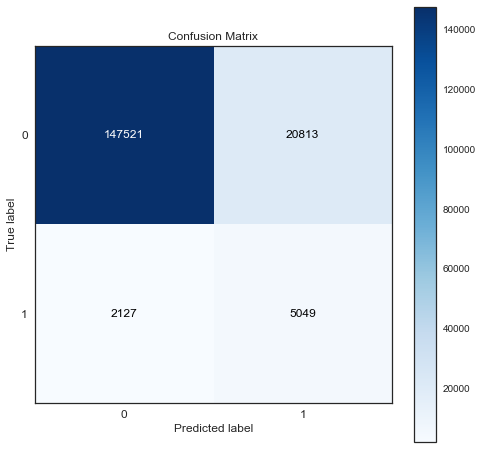

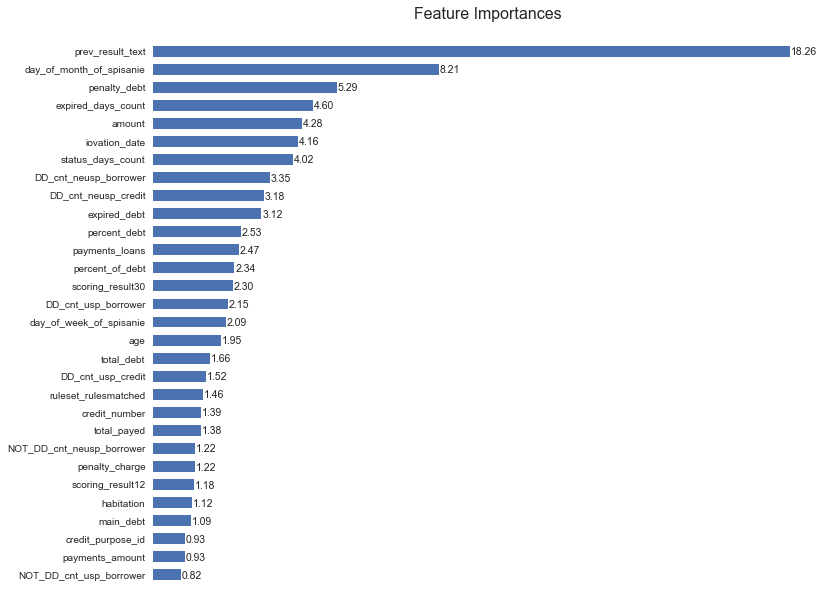

In [199]:
IDF.plot_score(clf, X_test, y_test)

# Results

In [209]:
test['prediction_proba'] = clf.predict_proba(X_test)[:,1]
writer = pd.ExcelWriter('V1_ES_DD_TEST_DATA_WITH_PREDICTIONS.xlsx')
test[['amount','is_success', 'prediction_proba']].to_excel(writer, 'ES_DD_TEST', index=False)
writer.save()

In [217]:
print (classification_report(pd.Series(clf.predict_proba(X_test)[:,1]).apply(lambda x: 1 if x>0.1 else 0), y_test))

             precision    recall  f1-score   support

          0       0.52      1.00      0.68     87913
          1       0.94      0.08      0.14     87597

avg / total       0.73      0.54      0.41    175510



In [130]:
writer = pd.ExcelWriter('data_dd.xlsx')
df.to_excel(writer,'DD_DATA', index=False)
writer.save()